# Part 2. Biochemical Pathways in Phenotypic Description Data
The purpose of this notebook is to determine how well networks generated using phenotypic description based similarity measurements through a variety of embedding methods correlate with information about gene membership in biochemical pathways, or additionally in a arbitrary grouping such as functional categories as well. The theory this is based on is that because phenotypes are at some level the consequence of molecular or other lower level processes, two genes which are involved in a common process or pathway are more likely to impact a shared phenotype or at least two phenotypes that share more characteristics than what might be expected due to random chance.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import time
import math
import sys
import gensim
import os
import warnings
import itertools
from collections import Counter, defaultdict
from inspect import signature
from scipy.stats import ks_2samp
from sklearn.metrics import precision_recall_curve, f1_score, auc
from sklearn.model_selection import train_test_split, KFold
from scipy import spatial

sys.path.append("../../oats")
from oats.utils.utils import save_to_pickle, load_from_pickle, merge_list_dicts, flatten
from oats.datasets.dataset import Dataset
from oats.datasets.groupings import Groupings
from oats.annotation.ontology import Ontology
from oats.annotation.annotation import write_annotations_to_tsv_file, read_annotations_from_tsv_file
from oats.graphs.pairwise import pairwise_doc2vec_onegroup, pairwise_counting_onegroup, pairwise_annotations_onegroup
from oats.graphs.pairwise import merge_edgelists, subset_edgelist_with_ids, pairwise_word2vec_onegroup
from oats.graphs.pairwise import remove_self_loops
from oats.graphs.indexed import IndexedGraph
from oats.graphs.models import train_logistic_regression_model, apply_logistic_regression_model
from oats.graphs.models import train_random_forest_model, apply_random_forest_model

mpl.rcParams["figure.dpi"] = 400
warnings.simplefilter('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
# Nested dictionary to summarize output with shape dict[method][(tag,metric)] --> value
# The dictionary is organized this way for printing within this notebook and saving as a csv file.
TAG = "biochemical pathways"
OUTPUT = defaultdict(dict)

### 2.1 Reading in dataset and subsetting based on membership in biochemical pathways
The dataset can be loaded from an existing dataset object that was saved as a pickle, or csv files can be loaded directly into a new dataset object. Subsetting here is done so that only genes which are mapped to atleast one of the categories from whatever groupings are being used (such as biochemical pathways) are retained. Any other filtering to reduce the number of genes present in the dataset can be done at this point.

In [3]:
# Reading in the entire dataset, subsetting for species and desired annotation types.
dataset = load_from_pickle("../data/pickles/full_dataset.pickle")
dataset.describe()
dataset.filter_by_species("ath")
dataset.collapse_by_all_gene_names()
dataset.filter_has_description()
dataset.filter_has_annotation()
dataset.describe()

Number of rows in the dataframe: 47151
Number of unique IDs:            47151
Number of unique descriptions:   16504
Number of unique gene name sets: 47151
Number of species represented:   6
Number of rows in the dataframe: 5972
Number of unique IDs:            5972
Number of unique descriptions:   3635
Number of unique gene name sets: 5972
Number of species represented:   1


In [4]:
# Subsetting the dataset to include only those genes that map to at least one group from some classification source.
groups = load_from_pickle(path="../data/pickles/pmn_pathways.pickle")
id_to_group_ids = groups.get_id_to_group_ids_dict(dataset.get_gene_dictionary())
group_mapped_ids = [k for (k,v) in id_to_group_ids.items() if len(v)>1]    
dataset.filter_with_ids(group_mapped_ids)
dataset.describe()

Number of rows in the dataframe: 444
Number of unique IDs:            444
Number of unique descriptions:   394
Number of unique gene name sets: 444
Number of species represented:   1


In [5]:
# Get the mappings again now that the data has been subset and see how many genes mapped to each group.
id_to_group_ids = groups.get_id_to_group_ids_dict(dataset.get_gene_dictionary())
group_id_to_ids = groups.get_group_id_to_ids_dict(dataset.get_gene_dictionary())
sorted_group_tuples = sorted(group_id_to_ids.items(), key=lambda x: len(x[1]), reverse=True)
print("{:<20}{:<20}{:<20}".format("Num Genes Mapped","Pathway ID", "Pathway Name"))
for group in sorted_group_tuples[:10]:
    print("{:<20}{:<20}{:<20}".format(len(group_id_to_ids[group[0]]), group[0], groups.get_long_name(group[0]))) 

Num Genes Mapped    Pathway ID          Pathway Name        
21                  PWY66-399           gluconeogenesis III 
21                  GLUCONEO-PWY        gluconeogenesis I   
19                  PWY-6733            sporopollenin precursors biosynthesis
19                  PWY-6803            phosphatidylcholine acyl editing
18                  PWY-1121            suberin monomers biosynthesis
18                  PWY-361             phenylpropanoid biosynthesis
17                  GLYCOLYSIS          glycolysis I (from glucose 6-phosphate)
16                  PWY-5484            glycolysis II (from fructose 6-phosphate)
16                  PWY-581             indole-3-acetate biosynthesis II
15                  PWY-5971            palmitate biosynthesis II (bacteria and plants)


### 2.2 Preprocessing of text descriptions, generating vocabularies, and other optional steps

In [ ]:
# Make a dictionary of descriptions with same quantity of words but randomly selected from the vocabulary.
from nltk.tokenize import word_tokenize
#descriptions = dataset.get_description_dictionary()
#annotations = dataset.get_annotations_dictionary()
#go_annotations = {k:[term for term in v if term[0:2]=="GO"] for k,v in annotations.items()}
#po_annotations = {k:[term for term in v if term[0:2]=="PO"] for k,v in annotations.items()}
#tokens = [w for w in itertools.chain.from_iterable(word_tokenize(desc) for desc in descriptions.values())]
#scrambled_descriptions = {k:" ".join(np.random.choice(tokens,len(word_tokenize(v)))) for k,v in descriptions.items()}

### 2.3 Generating vector representations, pairwise similarity matrices, and edgelists
This includes things like whether or not to do capitilization removal, lemmatization, stemming, etc. on the descriptions present in the dataset. This could also included things like scrambling the contexts of each description to establish a baseline performance measure. This could also include things like reducing the vocabulary size through the preprocessing methods given here but also through additional means such as provided a reduced (more specialized) vocabulary dictionary to the vectorizing functions so that only those words which are most likely to have meaning have positions with those vectors. Should also test other vectorization methods such as term-frequency inverse-document-frequency for weighting. Can also change how the feature selection is done for those vectors by altering whether the *n*-grams are based on word or characters, and what the range of *n* is. Also should add the thing about combining the term annotations are text into a single bag-of-words vector representation.

In [6]:
# Objects and dictionaries needed to build the list of edges for the full graph.
doc2vec_model_filename = "../gensim/enwiki_dbow/doc2vec.bin"
doc2vec_model = gensim.models.Doc2Vec.load(doc2vec_model_filename)
word2vec_model_filename = "../gensim/wiki_sg/word2vec.bin"
word2vec_model = gensim.models.Word2Vec.load(word2vec_model_filename)
ontology_filename = "../ontologies/mo.obo"
ontology = Ontology(ontology_filename)
descriptions = dataset.get_description_dictionary()
annotations = dataset.get_annotations_dictionary()
vocabulary = ontology.get_vocabulary()


# Generating the pairwise edgelist for some vanilla methods.
graphs = {} # A mapping between method names and graph objects containing edgelists and vector mappings.
graphs["doc2vec"] = pairwise_doc2vec_onegroup(doc2vec_model, descriptions, metric="cosine")
graphs["bagofwords"] = pairwise_counting_onegroup(descriptions, binary=False, metric="cosine") 
graphs["setofwords"] = pairwise_counting_onegroup(descriptions, binary=True, metric="cosine")
graphs["ontology"] = pairwise_annotations_onegroup(annotations, ontology, binary=True, metric="cosine")

# Generating the pairwise edgelists for some additional methods.
graphs["bag_w12gram"] = pairwise_counting_onegroup(descriptions, metric="cosine", binary=False, analyzer="word", ngram_range=(1,2), max_features=1000)
graphs["bag_c36gram"] = pairwise_counting_onegroup(descriptions, metric="cosine", binary=False, analyzer="char", ngram_range=(4,6), max_features=1000)
graphs["bag_reduced"] = pairwise_counting_onegroup(descriptions, metric="cosine", binary=False, vocabulary=vocabulary)
graphs["set_reduced"] = pairwise_counting_onegroup(descriptions, metric="cosine", binary=True, vocabulary=vocabulary)

# Generating the pairwise edgelists for some additional methods.
graphs["w2v_mean"] = pairwise_word2vec_onegroup(word2vec_model, descriptions, metric="cosine", method="mean")
graphs["w2v_max"] = pairwise_word2vec_onegroup(word2vec_model, descriptions, metric="cosine", method="max")
print("{} methods completed".format(len(graphs)))

10 methods completed


In [7]:
# Merging all of the edgelist dataframes together.
methods = list(graphs.keys())
edgelists = {k:v.edgelist for k,v in graphs.items()}
df = merge_edgelists(edgelists, default_value=0.000)
df = remove_self_loops(df)
df.tail(12)

,from,to,doc2vec,bagofwords,setofwords,ontology,bag_w12gram,bag_c36gram,bag_reduced,set_reduced,w2v_mean,w2v_max
98773,26038,27146,0.662657,1.000000,1.000000,0.495451,1.000000,0.985097,1.000000,1.000000,0.483421,0.271691
98774,26038,29884,0.523261,0.971382,0.908997,0.096487,0.975797,0.825860,0.951986,0.817426,0.613178,0.776168
98776,26235,26311,0.463067,1.000000,1.000000,0.159635,1.000000,1.000000,1.000000,1.000000,0.792742,1.026084
98777,26235,26437,0.469407,0.837779,0.823223,0.071440,0.833333,0.834855,0.828501,0.811018,0.847855,0.977570
98778,26235,27146,0.360845,1.000000,1.000000,0.402888,1.000000,1.000000,1.000000,1.000000,0.940904,0.909837
98779,26235,29884,0.454548,1.000000,1.000000,0.147987,1.000000,1.000000,1.000000,1.000000,0.815568,0.909988
98781,26311,26437,0.490126,1.000000,1.000000,0.147075,1.000000,0.986516,1.000000,1.000000,0.434798,0.231187
98782,26311,27146,0.372932,1.000000,1.000000,0.387628,1.000000,1.000000,1.000000,1.000000,0.496606,0.318651
98783,26311,29884,0.433687,1.000000,1.000000,0.241053,1.000000,1.000000,1.000000,1.000000,0.664192,0.775982
98785,26437,27146,0.334385,0.885292,0.875000,0.428130,0.795876,0.570942,0.878732,0.866369,0.386927,0.263506


### 2.4 Merging the edgelists with information about biochemical pathway membership

In [8]:
# Generate a column indicating whether or not the two genes have atleast one pathway in common.
df["common"] = df[["from","to"]].apply(lambda x: len(set(id_to_group_ids[x["from"]]).intersection(set(id_to_group_ids[x["to"]])))>0, axis=1)*1
print(Counter(df["common"].values))

Counter({0: 95895, 1: 2451})


### 2.5 Training a logistic regression or random forest models to combine multiple methods
The purpose of this section is to iteratively train models on subsections of the dataset using simple regression or machine learning approaches to predict a value from zero to one indicating indicating how likely is it that two genes share atleast one of the specified groups in common. The information input to these models is the distance scores provided by each method in some set of all the methods used in this notebook. The purpose is to see whether or not a function of these similarity scores specifically trained to the task of predicting common groupings is better able to used the distance metric information to report a score for this task.

In [9]:
# Iteratively create models for combining output values from multiple semantic similarity methods.
kf = KFold(n_splits=12, random_state=14271, shuffle=True)
df["lr"] = pd.Series()
for train,test in kf.split(df):
    lr_model = train_logistic_regression_model(df=df.iloc[train], predictor_columns=methods, target_column="common")
    df["lr"].iloc[test] = apply_logistic_regression_model(df=df.iloc[test], predictor_columns=methods, model=lr_model)
df["lr"] = 1-df["lr"]
methods.append("lr")

In [ ]:
# Iteratively create models for combining output values from multiple semantic similarity methods.
kf = KFold(n_splits=2, random_state=14271, shuffle=True)
df["rf"] = pd.Series()
for train,test in kf.split(df):
    rf_model = train_random_forest_model(df=df.iloc[train], predictor_columns=methods, target_column="common")
    df["rf"].iloc[test] = apply_random_forest_model(df=df.iloc[test],predictor_columns=methods, model=rf_model)
df["rf"] = 1-df["rf"]
methods.append("rf")

### 2.6 Do the edges joining genes that share atleast one pathways come from a different distribution?
The purpose of this section is to visualize kernel estimates for the distributions of distance or similarity scores generated by each of the methods tested for measuring semantic similarity or generating vector representations of the phenotype descriptions. Ideally, better methods should show better separation betwene the distributions for distance values between two genes involved in a common specified group or two genes that are not. Additionally, a statistical test is used to check whether these two distributions are significantly different from each other or not, although this is a less informative measure than the other tests used in subsequent sections, because it does not address how useful these differences in the distributions actually are for making predictions about group membership.

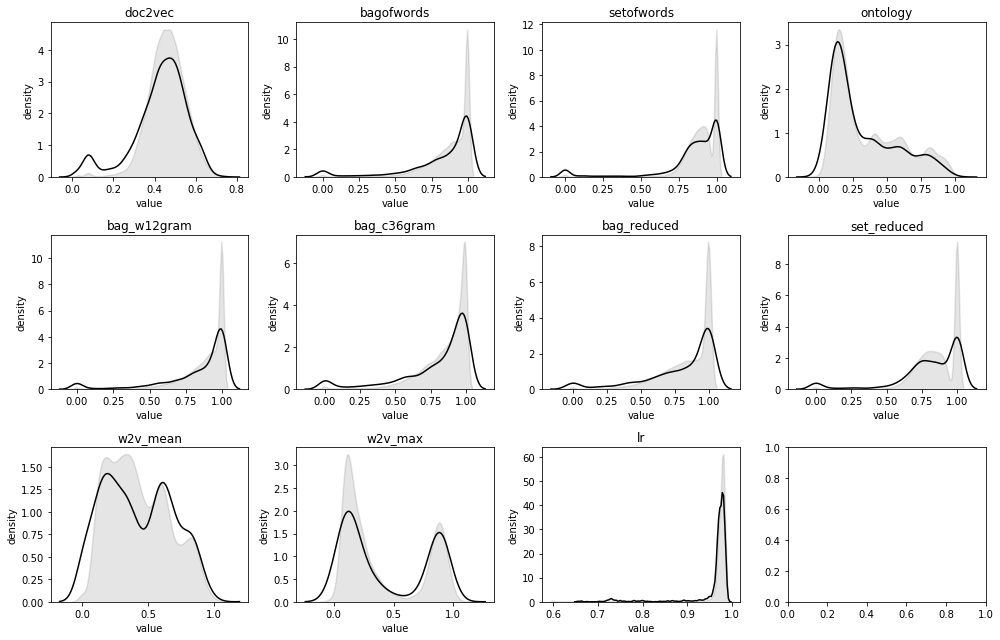

In [10]:
# Use Kolmogorov-Smirnov test to see if edges between genes that share a group come from a distinct distribution.
ppi_pos_dict = {name:(df[df["common"] > 0.00][name].values) for name in methods}
ppi_neg_dict = {name:(df[df["common"] == 0.00][name].values) for name in methods}
for name in methods:
    stat,p = ks_2samp(ppi_pos_dict[name],ppi_neg_dict[name])
    pos_mean = np.average(ppi_pos_dict[name])
    neg_mean = np.average(ppi_neg_dict[name])
    pos_n = len(ppi_pos_dict[name])
    neg_n = len(ppi_neg_dict[name])
    OUTPUT[name].update({(TAG,"mean_1"):pos_mean, (TAG,"mean_0"):neg_mean, (TAG,"n_1"):pos_n, (TAG,"n_0"):neg_n})
    OUTPUT[name].update({(TAG,"ks"):stat, (TAG,"ks_pval"):p})

# Show the kernel estimates for each distribution of weights for each method.
num_plots, plots_per_row, row_width, row_height = (len(methods), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for name,ax in zip(methods,axs.flatten()):
    ax.set_title(name)
    ax.set_xlabel("value")
    ax.set_ylabel("density")
    sns.kdeplot(ppi_pos_dict[name], color="black", shade=False, alpha=1.0, ax=ax)
    sns.kdeplot(ppi_neg_dict[name], color="black", shade=True, alpha=0.1, ax=ax) 
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()

### 2.7 Ranking each biochemical pathways by its phenotypic visibility
The purpose of this method is to look at which of the biochemical pathways (or whatever other arbitrary groupings) are the most easily recaptured using analysis of the text descriptions corresponding to the genes present in those biochemical pathways. This is done here by finding the average distance score for all the pairs of genes within each particular pathway or group for each method, then converting these values to ranks for ranking the pathways within a given method, then averaging the ranks across all methods. This is not necessarily extremely meaningful, if the pathway was involved in many phenotypes the pairwise similarity would not necessarily be very high, although the number of similar pairs might be higher than expected.

In [11]:
# Get all the average within-pathway phenotype similarity values for each method for each particular pathway.
group_id_to_ids = groups.get_group_id_to_ids_dict(dataset.get_gene_dictionary())
group_ids = list(group_id_to_ids.keys())
graph = IndexedGraph(df)
within_weights_dict = defaultdict(lambda: defaultdict(list))
all_weights_dict = {}
for method in methods:
    all_weights_dict[method] = df[method].values
    for group in group_ids:
        within_ids = group_id_to_ids[group]
        within_pairs = [(i,j) for i,j in itertools.permutations(within_ids,2)]
        within_weights_dict[method][group] = np.mean((graph.get_values(within_pairs, kind=method)))
heatmap_data = pd.DataFrame(within_weights_dict)
heatmap_data = heatmap_data.dropna(axis=0, inplace=False)
heatmap_data = heatmap_data.round(4).head(10)

In [12]:
# Find the average rank across methods of each pathway in terms of how low the mean within-group distance values were.
ranks = pd.DataFrame(within_weights_dict).rank()
ranks["average"] = ranks.mean(axis=1)
ranks.sort_values(by="average", inplace=True)
ranks.reset_index(inplace=True)
ranks["group_id"] = ranks["index"]
ranks["full_name"] = ranks["group_id"].apply(lambda x: groups.get_long_name(x))
ranks["n"] = ranks["group_id"].apply(lambda x: len(group_id_to_ids[x]))
ranks = ranks[["group_id", "n", "average","full_name",]]
ranks.head(20)

,group_id,n,average,full_name
0,ASPARAGINE-DEG1-PWY,2,2.636364,L-asparagine degradation I
1,PWY-6287,2,3.272727,neurosporene biosynthesis
2,PWY-6673,2,5.681818,caffeoylglucarate biosynthesis
3,PWY-5947,2,7.500000,lutein biosynthesis
4,PWY-5944,2,7.500000,zeaxanthin biosynthesis
5,PWY-4861,2,11.454545,UDP-&alpha;-D-galacturonate biosynthesis I (fr...
6,PWY-6295,2,17.500000,olivetol biosynthesis
7,PWY-84,2,17.500000,resveratrol biosynthesis
8,PWY-6457,6,22.454545,<i>trans</i>-cinnamoyl-CoA biosynthesis
9,PWY-6982,8,23.500000,umbelliferone biosynthesis


### 2.8 Predicting whether two genes belong to a common biochemical pathway
The purpose of this section is to see if whether or not two genes share atleast one common pathway can be predicted from the simalarity scores assigned using analysis of text similarity. The evaluation of predictability is done by reporting a precision and recall curve for each method, as well as remembering the area under the curve, and ratio between the area under the curve and the baseline (expected area when guessing randomly) for each method.

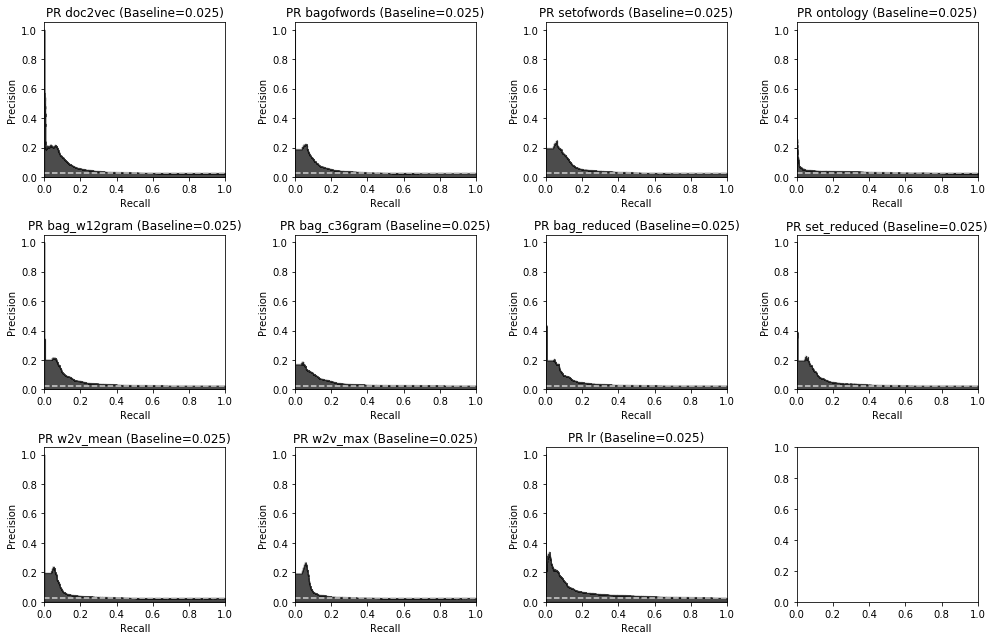

In [13]:
y_true_dict = {name:df["common"] for name in methods}
y_prob_dict = {name:(1 - df[name].values) for name in methods}
num_plots, plots_per_row, row_width, row_height = (len(methods), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for method,ax in zip(methods, axs.flatten()):
    
    # Obtaining the values and metrics.
    y_true, y_prob = y_true_dict[method], y_prob_dict[method]
    n_pos, n_neg = Counter(y_true)[1], Counter(y_true)[0]
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    baseline = Counter(y_true)[1]/len(y_true) 
    area = auc(recall, precision)
    auc_to_baseline_auc_ratio = area/baseline
    OUTPUT[method].update({(TAG,"auc"):area, (TAG,"baseline"):baseline, (TAG,"ratio"):auc_to_baseline_auc_ratio})

    # Producing the precision recall curve.
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    ax.step(recall, precision, color='black', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.7, color='black', **step_kwargs)
    ax.axhline(baseline, linestyle="--", color="lightgray")
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title("PR {0} (Baseline={1:0.3f})".format(method, baseline))
    
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()

### 2.9 Are genes in the same biochemical pathway ranked higher with respect to individual nodes?
This is a way of statistically seeing if for some value k, the graph ranks more edges from some particular gene to any other gene that it has a true protein-protein interaction with higher or equal to rank k, than we would expect due to random chance. This way of looking at the problem helps to be less ambiguous than the previous methods, because it gets at the core of how this would actually be used. In other words, we don't really care how much true information we're missing as long as we're still able to pick up some new useful information by building these networks, so even though we could be missing a lot, what's going on at the very top of the results? These results should be comparable to very strictly thresholding the network and saying that the remaining edges are our guesses at interactions. This is comparable to just looking at the far left-hand side of the precision recall curves, but just quantifies it slightly differently.

In [14]:
# Convert the undirected edgelist where an edge (j,i) is always implied by an edge (i,j) to a directed edgelist where
# both the (i,j) and (j,i) edges are explicity present in the dataframe. This is done so that we can make us of the
# groupby function to obtain all groups that contain all edges between some given node and everything its mapped to 
# by just grouping base on one of the columns specifying a node. This is easier than using a multi-indexed dataframe.
other_columns = df.columns[2:]
flipped_edges = df[flatten(["to","from",other_columns])]      # Create the flipped duplicate dataframe.
flipped_edges.columns = flatten(["from","to",other_columns])  # Rename the columns so it will stack correctly
df = pd.concat([df, flipped_edges])
df.drop_duplicates(keep="first", inplace=True)
print(df.shape)

(196692, 14)


In [15]:
k = 10 # The threshold of interest for gene ranks.
n = 100 # Number of Monte Carlo simulation iterations to do.

# What's the number of functional partners ranked k or higher in terms of phenotypic description similarity for 
# each gene? Also figure out the maximum possible number of functional partners that could be theoretically
# recovered in this dataset if recovered means being ranked as k or higher here.
df[list(methods)] = df.groupby("from")[list(methods)].rank()
ys = df[df["common"]==1][list(methods)].apply(lambda s: len([x for x in s if x<=k]))
ymax = sum(df.groupby("from")["common"].apply(lambda s: min(len([x for x in s if x==1]),k)))

# Monte Carlo simulation to see what the probability is of achieving each y-value by just randomly pulling k 
# edges for each gene rather than taking the top k ones that the similarity methods specifies when ranking.
ysims = [sum(df.groupby("from")["common"].apply(lambda s: len([x for x in s.sample(k) if x>0.00]))) for i in range(n)]
for method in methods:
    pvalue = len([ysim for ysim in ysims if ysim>=ys[method]])/float(n)
    OUTPUT[method][(TAG,"y")] = ys[method]
    OUTPUT[method][(TAG,"y_max")] = ymax
    OUTPUT[method][(TAG,"y_pval")] = pvalue

### 2.7 Predicting which biochemical pathway a specific gene belongs to
Can we learn associations between biochemical pathways and features extracted from text descriptions? The non-machine learning way to do this would be to create a representative data point for each pathway by first dropping the sample you want to make a prediction for, then trying to map them to each biochemical pathway. Would need to implement a fucntion for dropping k samples and then producing predictions for them. Second way would be to do the same drop k but just use mean similarity to all members of a given pathway. Take the mean of all the vector representations for that grouping, and use similarity to that to be predictive of whether or not a particular gene belongs in that grouping.

### 2.9 Predicting biochemical pathway membership based on representative mean vectors.
This section looks at how well the biochemical pathways that a particular gene is a member of can be predicted based on the similarity between the vector representation of the phenotype descriptions for that gene and the average vector for all the vector representations of phenotypes asociated with genes that belong to that particular pathway. In calculating the average vector for a given biochemical pathway, the vector corresponding to the gene that is currently being classified is not accounted for, to avoid overestimating the performance by including information about the ground truth during classification. This leads to missing information in the case of biochemical pathways that have only one member. This can be accounted for by only limiting the overall dataset to only include genes that belong to pathways that have atleast two genes mapped to them, and only including those pathways, or by removing the missing values before calculating the performance metrics below.

In [16]:
vector_dicts = {k:v.vector_dictionary for k,v in graphs.items()}
methods = list(vector_dicts.keys())

group_id_to_ids = groups.get_group_id_to_ids_dict(dataset.get_gene_dictionary())
group_ids = list(group_id_to_ids.keys())
pred_dict = defaultdict(lambda: defaultdict(dict))
true_dict = defaultdict(lambda: defaultdict(dict))
for method in methods:
    for group in group_ids:
        ids = group_id_to_ids[group]
        for identifier in list(dataset.get_gene_dictionary()):
            # What's the mean vector of this group, without this particular one that we're trying to calssify.
            vectors = np.array([vector_dicts[method][some_id] for some_id in ids if not some_id==identifier])
            mean_vector = vectors.mean(axis=0)
            this_vector = vector_dicts[method][identifier]
            pred_dict[method][identifier][group] = 1-spatial.distance.cosine(mean_vector, this_vector)
            true_dict[method][identifier][group] = (identifier in group_id_to_ids[group])*1

In [ ]:
num_plots, plots_per_row, row_width, row_height = (len(methods), 4, 14, 3)
fig,axs = plt.subplots(math.ceil(num_plots/plots_per_row), plots_per_row, squeeze=False)
for method,ax in zip(methods, axs.flatten()):
    
    # Obtaining the values and metrics.
    y_true = pd.DataFrame(true_dict[method]).as_matrix().flatten()
    y_prob = pd.DataFrame(pred_dict[method]).as_matrix().flatten()
    indices_to_keep = (~np.isnan(y_true+y_prob))
    y_true, y_prob = y_true[indices_to_keep], y_prob[indices_to_keep]
    n_pos, n_neg = Counter(y_true)[1], Counter(y_true)[0]
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    baseline = Counter(y_true)[1]/len(y_true) 
    area = auc(recall, precision)
    auc_to_baseline_auc_ratio = area/baseline
    OUTPUT[method].update({(TAG,"class_auc"):area, (TAG,"class_baseline"):baseline, (TAG,"class_ratio"):auc_to_baseline_auc_ratio})

    # Producing the precision recall curve.
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    ax.step(recall, precision, color='black', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.7, color='black', **step_kwargs)
    ax.axhline(baseline, linestyle="--", color="lightgray")
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title("PR {0} (Baseline={1:0.3f})".format(method, baseline))
    
fig.set_size_inches(row_width, row_height*math.ceil(num_plots/plots_per_row))
fig.tight_layout()
fig.show()

### 2.10 Predicting biochemical pathway membership based on mean similarity values.
This section looks at how well the biochemical pathways that a particular gene is a member of can be predicted based on the average similarity between the vector representationt of the phenotype descriptions for that gene and each of the vector representations for other phenotypes associated with genes that belong to that particular pathway. In calculating the average similarity to other genes from a given biochemical pathway, the gene that is currently being classified is not accounted for, to avoid overestimating the performance by including information about the ground truth during classification. This leads to missing information in the case of biochemical pathways that have only one member. This can be accounted for by only limiting the overall dataset to only include genes that belong to pathways that have atleast two genes mapped to them, and only including those pathways, or by removing the missing values before calculating the performance metrics below.

In [ ]:
graph = IndexedGraph(df)
group_id_to_ids = groups.get_reverse_dict(dataset.get_gene_dictionary())
group_ids = list(group_id_to_ids.keys())
pred_dict = defaultdict(lambda: defaultdict(dict))
true_dict = defaultdict(lambda: defaultdict(dict))
for identifier in list(dataset.get_gene_dictionary()):
    for group in group_ids:
        ids_in_this_group = group_id_to_ids[group]
        if identifier in ids_in_this_group:
            ids_in_this_group.remove(identifier)
        edges = []
        edges.extend([(identifier,other) for other in ids_in_this_group])
        edges.extend([(other,identifier) for other in ids_in_this_group])
        for method in methods:
            pred_dict[method][identifier][group] = np.mean(graph.get_values(edges, method))
            true_dict[method][identifier][group] = (identifier in group_id_to_ids[group])*1                                      

### 2.10 Summarizing the results for this notebook

In [ ]:
results = pd.DataFrame(OUTPUT).transpose()
results